In [2]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 加载已训练的模型
model = load_model('updated_ResNet50V2_Model.h5')

# 创建测试数据生成器
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    'fer2013/test',  # 测试数据目录
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# 在测试数据上评估模型
test_loss, test_accuracy = model.evaluate(test_data)
print(f"测试集准确度: {test_accuracy:.4f}")

Found 7178 images belonging to 7 classes.


C:\Users\Inmay\PycharmProjects\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 80s 691ms/step - accuracy: 0.3018 - loss: 2.0342
测试集准确度: 0.3534


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 获取预测结果
test_data.reset()
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# 获取真实标签
y_true = test_data.classes

# 获取类别名称
class_names = list(test_data.class_indices.keys())

# 生成混淆矩阵
cm = confusion_matrix(y_true, y_pred_classes)
print("混淆矩阵:")
print(cm)

# 生成分类报告（包含精确度、召回率、F1分数等）
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("分类报告:")
print(report)

113/113 ━━━━━━━━━━━━━━━━━━━━ 80s 702ms/step
混淆矩阵:
[[233   2 494  98   6  64  61]
 [ 10   0  88   8   0   2   3]
 [ 72   3 492 166  11 100 180]
 [ 44  17 118 560 960  20  55]
 [265  43 351 126  98 191 159]
 [131   8 423 156  15 459  55]
 [  5   1  61  56   8   5 695]]
分类报告:
              precision    recall  f1-score   support

       angry       0.31      0.24      0.27       958
     disgust       0.00      0.00      0.00       111
        fear       0.24      0.48      0.32      1024
       happy       0.48      0.32      0.38      1774
     neutral       0.09      0.08      0.08      1233
         sad       0.55      0.37      0.44      1247
    surprise       0.58      0.84      0.68       831

    accuracy                           0.35      7178
   macro avg       0.32      0.33      0.31      7178
weighted avg       0.37      0.35      0.35      7178



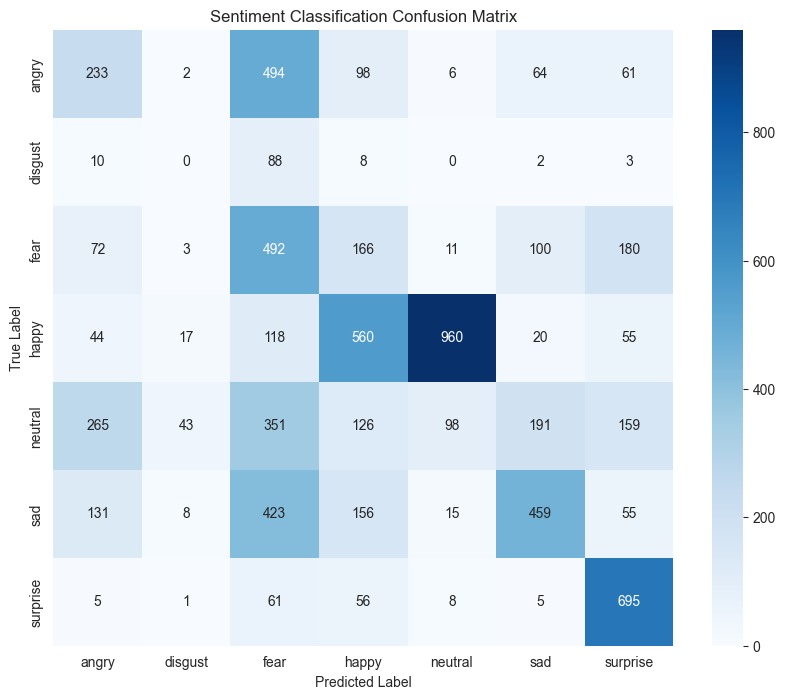

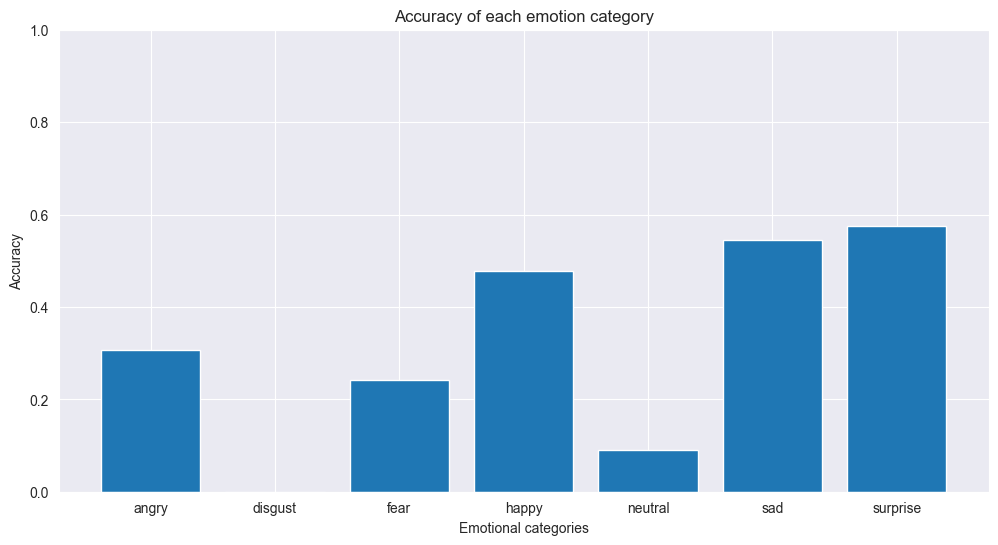

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制混淆矩阵热图
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Sentiment Classification Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# 绘制每个类别的准确度柱状图
plt.figure(figsize=(12, 6))
report_dict = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
accuracies = [report_dict[label]['precision'] for label in class_names]
plt.bar(class_names, accuracies)
plt.xlabel('Emotional categories')
plt.ylabel('Accuracy')
plt.title('Accuracy of each emotion category')
plt.ylim(0, 1)
plt.savefig('emotion_accuracies.png')
plt.show()

In [5]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_data = datagen.flow_from_directory('fer2013/train', target_size=(48, 48), color_mode='grayscale', batch_size=64, class_mode='categorical', subset='training')



Found 22968 images belonging to 7 classes.


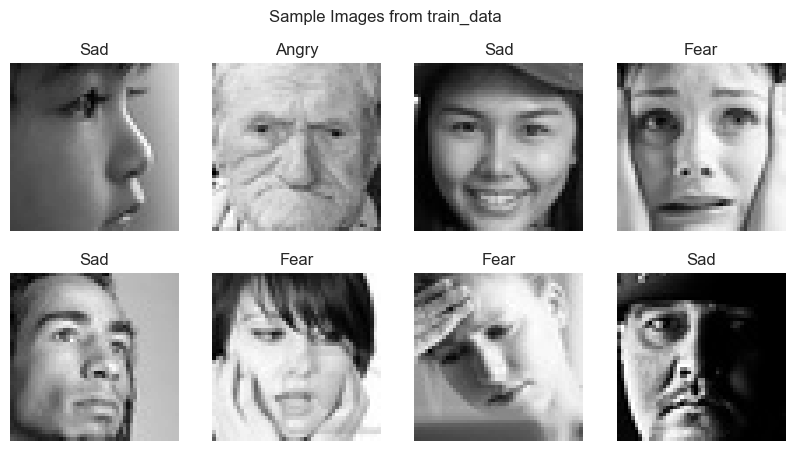

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 取一批图像和标签（第一批）
images, labels = next(train_data)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# 可视化前16张图像
plt.figure(figsize=(10, 5))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    label_index = np.argmax(labels[i])
    plt.title(emotion_labels[label_index])
    plt.axis('off')
plt.suptitle('Sample Images from train_data')
plt.show()

ONNX 模型输入名称: input
预测表情: Happy (置信度: 0.72)


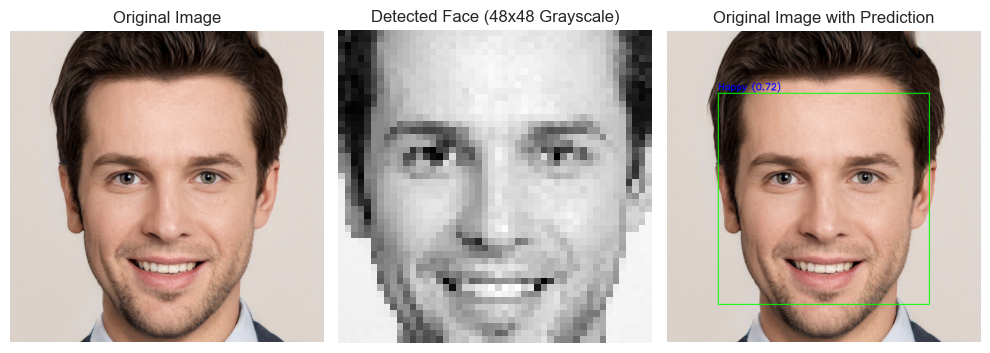

In [7]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt

# 1. 加载模型
session = ort.InferenceSession("face_emotion_model.onnx")
input_name = session.get_inputs()[0].name
print("ONNX 模型输入名称:", input_name)

# 2. 加载人脸检测器
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 3. 读取图像
img_path = 'images/1.png'  # ← 你测试的图片路径
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 4. 检测人脸
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

# 5. 处理每一张检测到的人脸
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

for (x, y, w, h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_gray_resized = cv2.resize(roi_gray, (48, 48))
    roi_input = np.expand_dims(roi_gray_resized, axis=[0, -1]) / 255.0
    roi_input = roi_input.astype(np.float32)

    outputs = session.run(None, {input_name: roi_input})
    prediction = outputs[0][0]
    emotion_index = np.argmax(prediction)
    emotion_label = labels[emotion_index]
    confidence = prediction[emotion_index]

    # 6. 显示图像
    print(f"预测表情: {emotion_label} (置信度: {confidence:.2f})")

    # 在图上画框和文字
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, f"{emotion_label} ({confidence:.2f})", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # 显示灰度图
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Detected Face (48x48 Grayscale)")
    plt.imshow(roi_gray_resized, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Original Image with Prediction")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()


模型加载成功
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
预测表情: Happy (置信度: 0.94)


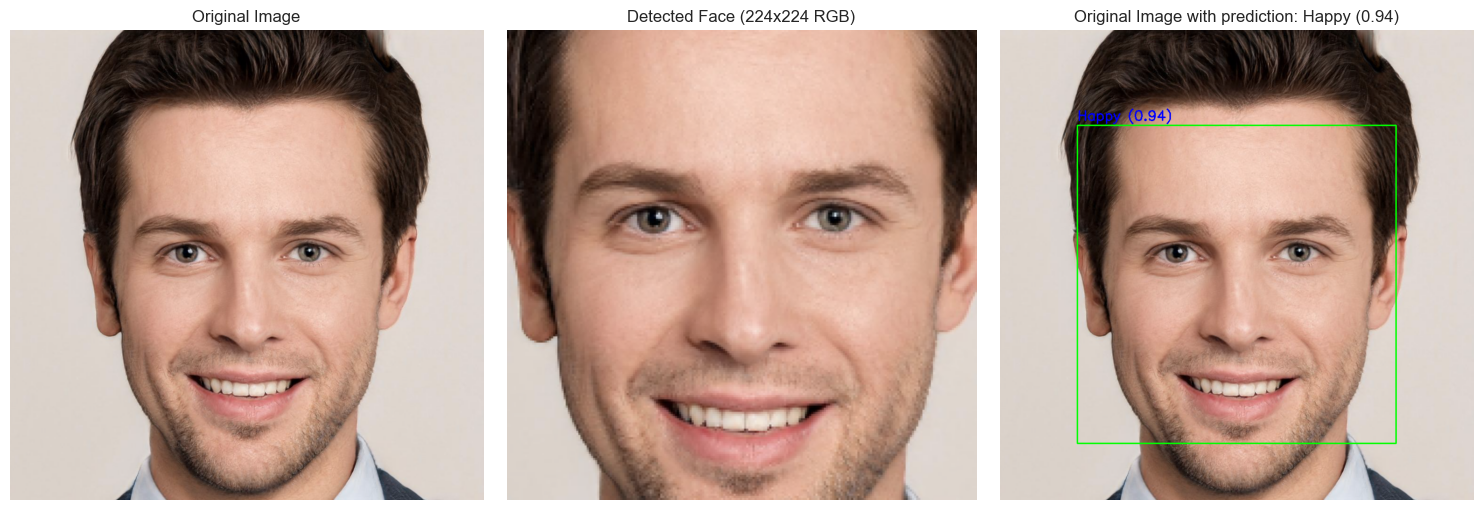

In [7]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. 加载模型
model = tf.keras.models.load_model("ResNet50V2_Model.h5")
print("模型加载成功")

# 2. 加载人脸检测器
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# 3. 读取图像
img_path = 'images/1.png'  # ← 你测试的图片路径
image = cv2.imread(img_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 4. 检测人脸
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

# 5. 处理每一张检测到的人脸
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

for (x, y, w, h) in faces:
    # 提取面部区域 (使用彩色图像)
    face_roi = image[y:y+h, x:x+w]
    
    # 调整大小到模型输入尺寸 (224x224 RGB)
    face_roi_resized = cv2.resize(face_roi, (224, 224))
    
    # 预处理为模型输入格式
    face_input = face_roi_resized / 255.0  # 归一化到 [0,1]
    face_input = np.expand_dims(face_input, axis=0)  # 添加批次维度
    
    # 进行预测
    prediction = model.predict(face_input)
    emotion_index = np.argmax(prediction[0])
    emotion_label = labels[emotion_index]
    confidence = prediction[0][emotion_index]

    # 6. 显示图像
    print(f"预测表情: {emotion_label} (置信度: {confidence:.2f})")

    # 在图上画框和文字
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, f"{emotion_label} ({confidence:.2f})", (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # 显示处理后的图像
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title("Detected Face (224x224 RGB)")
    plt.imshow(cv2.cvtColor(face_roi_resized, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Original Image with prediction: {emotion_label} ({confidence:.2f})")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [2]:
import cv2
import tensorflow as tf
import numpy as np

# Load model
model = tf.keras.models.load_model('ResNet50V2_Model.h5')

# Load haarcascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Open video
cap = cv2.VideoCapture(0)

# Emotion labels
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Convert to grayscale for face detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    for (x, y, w, h) in faces:
        # Extract face region
        face_roi = frame[y:y+h, x:x+w]
        
        # Resize to match model input (224x224 RGB)
        face_roi = cv2.resize(face_roi, (224, 224))
        
        # Preprocess for model input
        face_roi = face_roi / 255.0  # Normalize to [0,1]
        face_roi = np.expand_dims(face_roi, axis=0)  # Add batch dimension
        
        # Predict emotion
        prediction = model.predict(face_roi)
        emotion = np.argmax(prediction)
        emotion_text = labels[emotion]
        
        # Display confidence percentage
        confidence = round(float(prediction[0][emotion]) * 100, 2)
        display_text = f"{emotion_text}: {confidence}%"
        
        # Display result
        cv2.putText(frame, display_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)

    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━

KeyboardInterrupt: 

Found 12 images belonging to 7 classes.


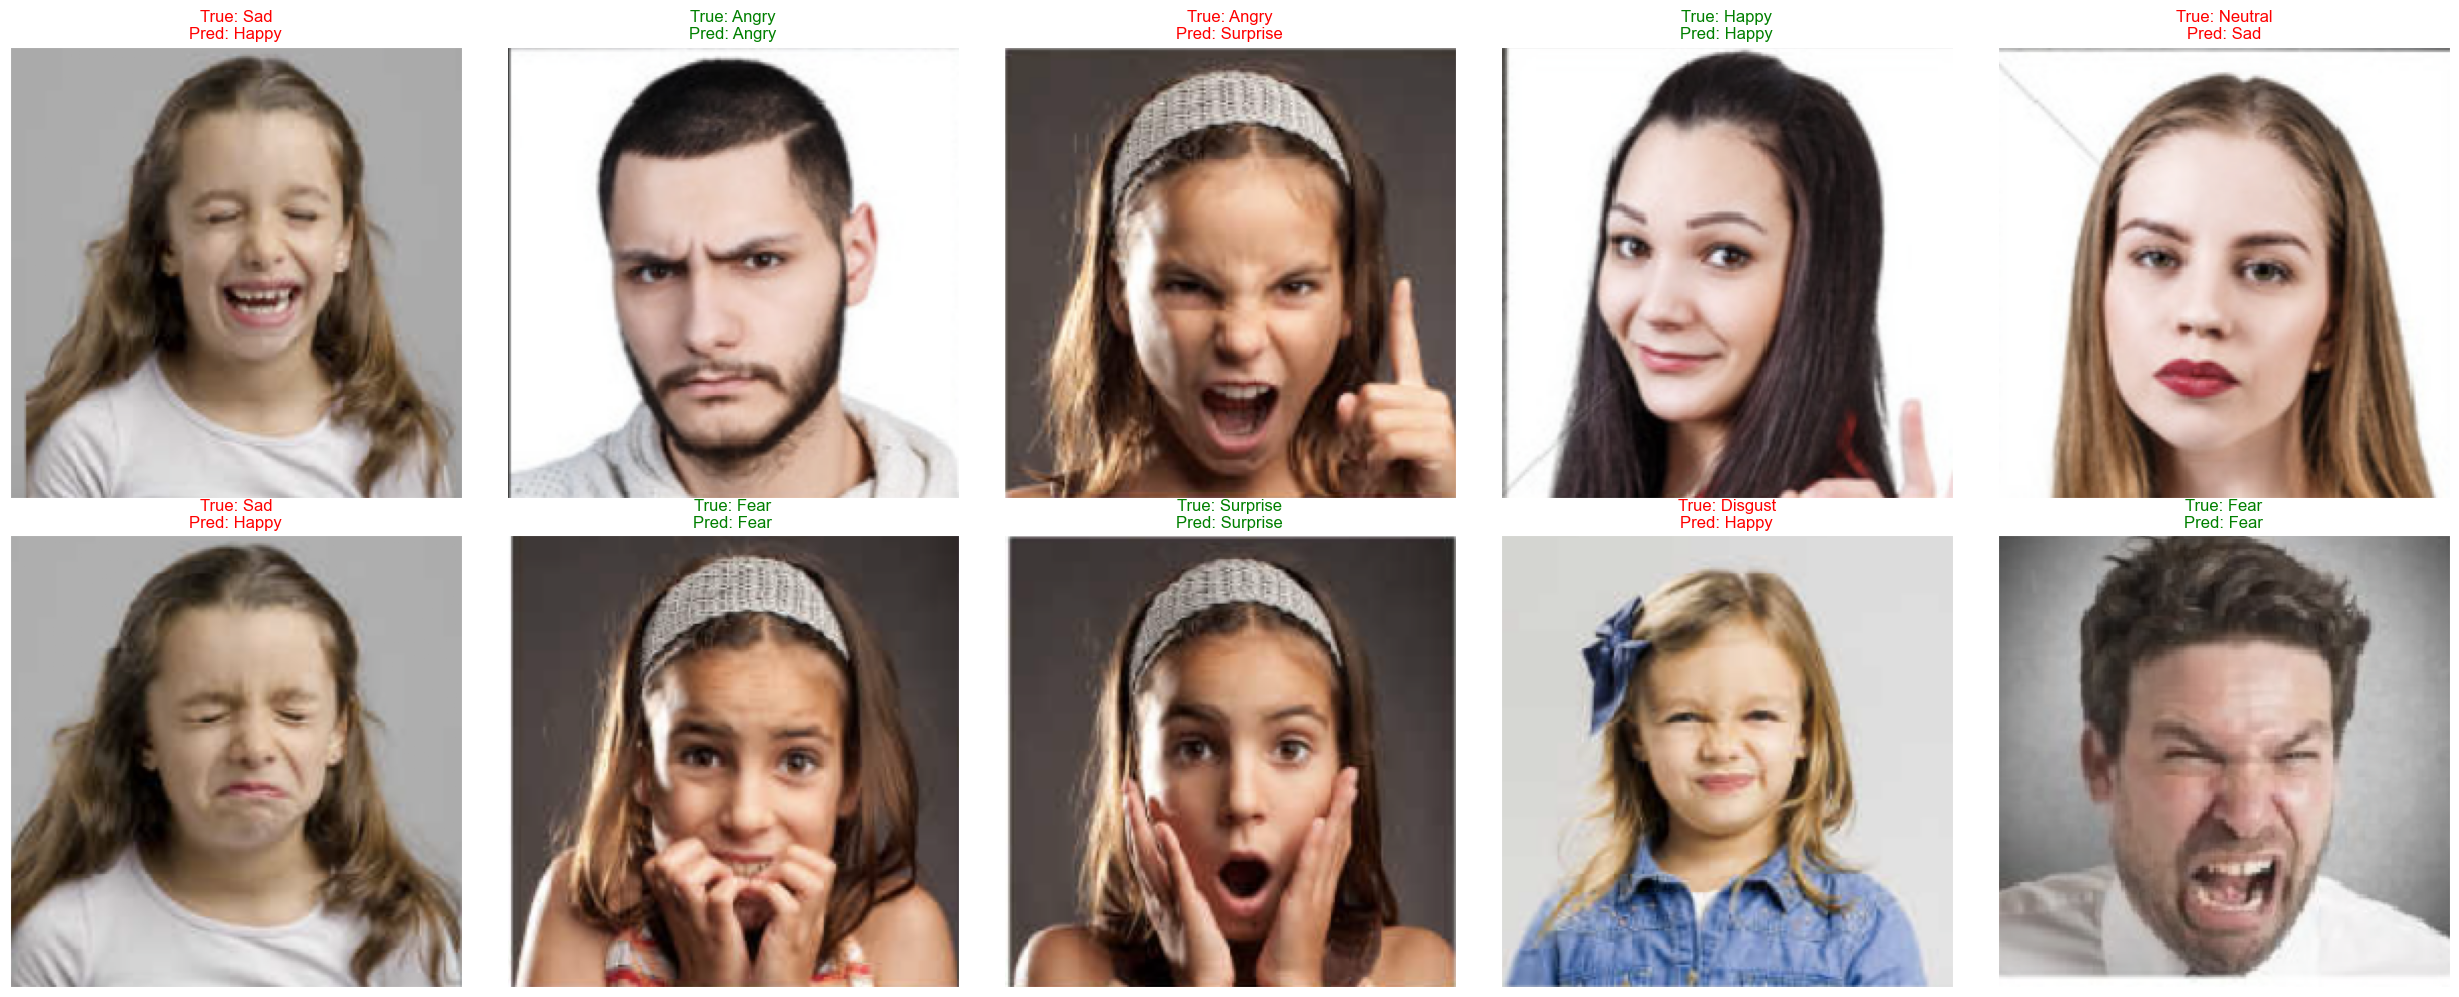

In [17]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

img_shape = 224
batch_size = 64
test_data_path = 'images/test/'
# 加载已训练的模型
ResNet50V2_Model = load_model('updated_ResNet50V2_Model.h5')
Emotion_Classes = ['Angry',
                   'Disgust',
                   'Fear',
                   'Happy',
                   'Neutral',
                   'Sad',
                   'Surprise']
# Shuffling Test Data to show diffrent classes
test_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
)

test_generator = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape, img_shape),
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
)
# Display 10 random pictures from the dataset with their labels

images, labels = test_generator[0]
true_batch_size = images.shape[0]  # 实际图像数量，最多为 12

# 随机选取最多 10 张图像的索引（不能超过实际数量）
select_num = min(10, true_batch_size)
random_indices = np.random.choice(true_batch_size, size=select_num, replace=False)

# 显示图像
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flat

for i in range(select_num):
    img = images[random_indices[i]]
    true_label = np.argmax(labels[random_indices[i]])
    pred_label = np.argmax(ResNet50V2_Model.predict(tf.expand_dims(img, axis=0), verbose=0))

    color = "green" if true_label == pred_label else "red"
    axes[i].imshow(img)
    axes[i].set_title(f"True: {Emotion_Classes[true_label]}\nPred: {Emotion_Classes[pred_label]}", color=color)

# 隐藏多余 subplot
for i in range(select_num, 10):
    axes[i].axis("off")

plt.tight_layout()
plt.show()